In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import itertools

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
train = pd.read_csv(r'C:\Users\Rahul Kanwal\Desktop\SBSPS-Challenge-1497-Optimized-Warehouse-Management-of-Perishable-Goods-for-a-Food-Delivery-Company\final_train.csv')
test = pd.read_csv(r'C:\Users\Rahul Kanwal\Desktop\SBSPS-Challenge-1497-Optimized-Warehouse-Management-of-Perishable-Goods-for-a-Food-Delivery-Company\final_test.csv')

In [44]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,647,56,TYPE_C,2.0,Beverages,Thai,177
1,1018704,2,55,1885,135.83,152.29,0,0,647,56,TYPE_C,2.0,Beverages,Thai,323
2,1196273,3,55,1885,132.92,133.92,0,0,647,56,TYPE_C,2.0,Beverages,Thai,96
3,1116527,4,55,1885,135.86,134.86,0,0,647,56,TYPE_C,2.0,Beverages,Thai,163
4,1343872,5,55,1885,146.50,147.50,0,0,647,56,TYPE_C,2.0,Beverages,Thai,215


In [45]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
2,1453211,149,55,1885,157.14,158.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai
3,1262599,150,55,1885,159.14,157.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai
4,1495848,151,55,1885,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai


In [3]:
# SLice the full original train data into two sets: train and validation set
training = train[train['week'] <= 130].copy()
validation = train[(train['week'] >= 131) & (train['week'] <= 145)].copy()

In [4]:
train_ts = training[['week','center_id','meal_id','num_orders']]

In [5]:
train_ts = train_ts.sort_values(by=['center_id','meal_id','week'])

In [6]:
train_ts['center_meal_combo_id'] = train_ts[['center_id','meal_id']].apply(lambda x: str(x[0])+'-'+str(x[1]), axis=1)

In [50]:
train_ts.head()

,week,center_id,meal_id,num_orders,center_meal_combo_id
82183,1,10,1062,865,10-1062
82184,2,10,1062,782,10-1062
82185,3,10,1062,851,10-1062
82186,4,10,1062,1202,10-1062
82187,5,10,1062,958,10-1062


In [7]:
basic_raw_time_series = pd.DataFrame(data=np.sort(train_ts['week'].value_counts().index.to_list()), columns=['week'])
basic_raw_time_series

,week
0,1
1,2
2,3
3,4
4,5
...,...
125,126
126,127
127,128
128,129


In [8]:
df = pd.date_range(start='2000-01-01', periods=130, freq='W').to_frame(index=False, name='ds')
basic_raw_time_series = pd.concat([basic_raw_time_series,df], axis=1)

In [53]:
basic_raw_time_series

,week,ds
0,1,2000-01-02
1,2,2000-01-09
2,3,2000-01-16
3,4,2000-01-23
4,5,2000-01-30
...,...,...
125,126,2002-05-26
126,127,2002-06-02
127,128,2002-06-09
128,129,2002-06-16


In [9]:
full_raw_time_series = pd.DataFrame()
for i in range(3927):
    full_raw_time_series = full_raw_time_series.append(basic_raw_time_series, ignore_index=True)

In [55]:
full_raw_time_series

,week,ds
0,1,2000-01-02
1,2,2000-01-09
2,3,2000-01-16
3,4,2000-01-23
4,5,2000-01-30
...,...,...
510505,126,2002-05-26
510506,127,2002-06-02
510507,128,2002-06-09
510508,129,2002-06-16


In [10]:
meal_list = np.sort(training['meal_id'].unique())
center_list = np.sort(training['center_id'].unique())
center_meal_combo = []
for r in itertools.product(center_list, meal_list): 
    center_meal_combo.append(r)
center_meal_combo = pd.DataFrame(center_meal_combo, columns=['center_id', 'meal_id'])
center_meal_combo['centre_meal'] = center_meal_combo[['center_id','meal_id']].apply(lambda x: str(x[0])+'-'+str(x[1]), axis=1)

In [11]:
full_combo_id = pd.DataFrame()
for combo in list(center_meal_combo['centre_meal']):
    combo_df = pd.DataFrame(data=[combo]*130, columns=['center_meal_combo_id'])
    full_combo_id = full_combo_id.append(combo_df, ignore_index=True)

In [58]:
full_combo_id

,center_meal_combo_id
0,10-1062
1,10-1062
2,10-1062
3,10-1062
4,10-1062
...,...
510505,186-2956
510506,186-2956
510507,186-2956
510508,186-2956


In [12]:
full_raw_time_series = pd.concat([full_raw_time_series, full_combo_id], axis=1)

In [60]:
full_raw_time_series

,week,ds,center_meal_combo_id
0,1,2000-01-02,10-1062
1,2,2000-01-09,10-1062
2,3,2000-01-16,10-1062
3,4,2000-01-23,10-1062
4,5,2000-01-30,10-1062
...,...,...,...
510505,126,2002-05-26,186-2956
510506,127,2002-06-02,186-2956
510507,128,2002-06-09,186-2956
510508,129,2002-06-16,186-2956


In [13]:
train_time_series = train_ts.merge(basic_raw_time_series, on='week')

In [62]:
train_time_series.head()

,week,center_id,meal_id,num_orders,center_meal_combo_id,ds
0,1,10,1062,865,10-1062,2000-01-02
1,1,10,1109,2672,10-1109,2000-01-02
2,1,10,1198,269,10-1198,2000-01-02
3,1,10,1207,769,10-1207,2000-01-02
4,1,10,1216,54,10-1216,2000-01-02


In [14]:
train_time_series = train_time_series.sort_values(by=['center_id','meal_id','week'])

In [15]:
train_time_series['ds'] = pd.to_datetime(train_time_series['ds'], format='%Y-%m-%d')

In [65]:
train_time_series

,week,center_id,meal_id,num_orders,center_meal_combo_id,ds
0,1,10,1062,865,10-1062,2000-01-02
2922,2,10,1062,782,10-1062,2000-01-09
5818,3,10,1062,851,10-1062,2000-01-16
8717,4,10,1062,1202,10-1062,2000-01-23
11606,5,10,1062,958,10-1062,2000-01-30
...,...,...,...,...,...,...
348174,112,186,2956,82,186-2956,2002-02-17
351486,113,186,2956,40,186-2956,2002-02-24
354786,114,186,2956,27,186-2956,2002-03-03
358072,115,186,2956,15,186-2956,2002-03-10


In [16]:
new_full_raw_time_series = pd.merge(full_raw_time_series, train_time_series, how='outer', on=['center_meal_combo_id','week'])

In [17]:
new_full_raw_time_series['y_actual'] = new_full_raw_time_series['num_orders'].apply(lambda x: x if np.isnan(x)==False else 0)

In [68]:
new_full_raw_time_series

,week,ds_x,center_meal_combo_id,center_id,meal_id,num_orders,ds_y,y_actual
0,1,2000-01-02,10-1062,10.0,1062.0,865.0,2000-01-02,865.0
1,2,2000-01-09,10-1062,10.0,1062.0,782.0,2000-01-09,782.0
2,3,2000-01-16,10-1062,10.0,1062.0,851.0,2000-01-16,851.0
3,4,2000-01-23,10-1062,10.0,1062.0,1202.0,2000-01-23,1202.0
4,5,2000-01-30,10-1062,10.0,1062.0,958.0,2000-01-30,958.0
...,...,...,...,...,...,...,...,...
510505,126,2002-05-26,186-2956,NaN,NaN,NaN,NaT,0.0
510506,127,2002-06-02,186-2956,NaN,NaN,NaN,NaT,0.0
510507,128,2002-06-09,186-2956,NaN,NaN,NaN,NaT,0.0
510508,129,2002-06-16,186-2956,NaN,NaN,NaN,NaT,0.0


In [18]:
new_full_raw_time_series = new_full_raw_time_series.drop(['center_id','meal_id','num_orders','ds_y'], axis=1, inplace=False)

In [19]:
new_full_raw_time_series = new_full_raw_time_series.rename(columns={'ds_x':'ds', 'y_actual':'y'})

In [71]:
new_full_raw_time_series

,week,ds,center_meal_combo_id,y
0,1,2000-01-02,10-1062,865.0
1,2,2000-01-09,10-1062,782.0
2,3,2000-01-16,10-1062,851.0
3,4,2000-01-23,10-1062,1202.0
4,5,2000-01-30,10-1062,958.0
...,...,...,...,...
510505,126,2002-05-26,186-2956,0.0
510506,127,2002-06-02,186-2956,0.0
510507,128,2002-06-09,186-2956,0.0
510508,129,2002-06-16,186-2956,0.0


In [36]:
total_predictions=pd.DataFrame()
i = 0
n = len(center_meal_combo)
for combo in list(center_meal_combo['centre_meal']):
    combo_time_series = new_full_raw_time_series.loc[new_full_raw_time_series['center_meal_combo_id'] == combo,['ds','y']]
    # Instantiate a Prophet object and fit it to our time series
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(combo_time_series)
    # Make a dataframe of future dates
    future = m.make_future_dataframe(freq='W', periods=10)
    # Make predictions on future dates
    forecast = m.predict(future)
    mini_predictions = forecast.loc[:,['ds','yhat']]
    combo_series = pd.DataFrame([combo]*145, columns=['centre_meal_combo_id'])
    predictions = pd.concat([combo_series, mini_predictions], axis=1)
    total_predictions = total_predictions.append(predictions, ignore_index=True)
    i += 1
    print('Model Created:', i, "out of", n)

Model Created: 1 out of 3927
Model Created: 2 out of 3927
Model Created: 3 out of 3927
Model Created: 4 out of 3927
Model Created: 5 out of 3927
Model Created: 6 out of 3927
Model Created: 7 out of 3927
Model Created: 8 out of 3927
Model Created: 9 out of 3927
Model Created: 10 out of 3927
Model Created: 11 out of 3927
Model Created: 12 out of 3927
Model Created: 13 out of 3927
Model Created: 14 out of 3927
Model Created: 15 out of 3927
Model Created: 16 out of 3927
Model Created: 17 out of 3927
Model Created: 18 out of 3927
Model Created: 19 out of 3927
Model Created: 20 out of 3927
Model Created: 21 out of 3927
Model Created: 22 out of 3927
Model Created: 23 out of 3927
Model Created: 24 out of 3927
Model Created: 25 out of 3927
Model Created: 26 out of 3927
Model Created: 27 out of 3927
Model Created: 28 out of 3927
Model Created: 29 out of 3927
Model Created: 30 out of 3927
Model Created: 31 out of 3927
Model Created: 32 out of 3927
Model Created: 33 out of 3927
Model Created: 34 o

Model Created: 269 out of 3927
Model Created: 270 out of 3927
Model Created: 271 out of 3927
Model Created: 272 out of 3927
Model Created: 273 out of 3927
Model Created: 274 out of 3927
Model Created: 275 out of 3927
Model Created: 276 out of 3927
Model Created: 277 out of 3927
Model Created: 278 out of 3927
Model Created: 279 out of 3927
Model Created: 280 out of 3927
Model Created: 281 out of 3927
Model Created: 282 out of 3927
Model Created: 283 out of 3927
Model Created: 284 out of 3927
Model Created: 285 out of 3927
Model Created: 286 out of 3927
Model Created: 287 out of 3927
Model Created: 288 out of 3927
Model Created: 289 out of 3927
Model Created: 290 out of 3927
Model Created: 291 out of 3927
Model Created: 292 out of 3927
Model Created: 293 out of 3927
Model Created: 294 out of 3927
Model Created: 295 out of 3927
Model Created: 296 out of 3927
Model Created: 297 out of 3927
Model Created: 298 out of 3927
Model Created: 299 out of 3927
Model Created: 300 out of 3927
Model Cr

Model Created: 534 out of 3927
Model Created: 535 out of 3927
Model Created: 536 out of 3927
Model Created: 537 out of 3927
Model Created: 538 out of 3927
Model Created: 539 out of 3927
Model Created: 540 out of 3927
Model Created: 541 out of 3927
Model Created: 542 out of 3927
Model Created: 543 out of 3927
Model Created: 544 out of 3927
Model Created: 545 out of 3927
Model Created: 546 out of 3927
Model Created: 547 out of 3927
Model Created: 548 out of 3927
Model Created: 549 out of 3927
Model Created: 550 out of 3927
Model Created: 551 out of 3927
Model Created: 552 out of 3927
Model Created: 553 out of 3927
Model Created: 554 out of 3927
Model Created: 555 out of 3927
Model Created: 556 out of 3927
Model Created: 557 out of 3927
Model Created: 558 out of 3927
Model Created: 559 out of 3927
Model Created: 560 out of 3927
Model Created: 561 out of 3927
Model Created: 562 out of 3927
Model Created: 563 out of 3927
Model Created: 564 out of 3927
Model Created: 565 out of 3927
Model Cr

Model Created: 799 out of 3927
Model Created: 800 out of 3927
Model Created: 801 out of 3927
Model Created: 802 out of 3927
Model Created: 803 out of 3927
Model Created: 804 out of 3927
Model Created: 805 out of 3927
Model Created: 806 out of 3927
Model Created: 807 out of 3927
Model Created: 808 out of 3927
Model Created: 809 out of 3927
Model Created: 810 out of 3927
Model Created: 811 out of 3927
Model Created: 812 out of 3927
Model Created: 813 out of 3927
Model Created: 814 out of 3927
Model Created: 815 out of 3927
Model Created: 816 out of 3927
Model Created: 817 out of 3927
Model Created: 818 out of 3927
Model Created: 819 out of 3927
Model Created: 820 out of 3927
Model Created: 821 out of 3927
Model Created: 822 out of 3927
Model Created: 823 out of 3927
Model Created: 824 out of 3927
Model Created: 825 out of 3927
Model Created: 826 out of 3927
Model Created: 827 out of 3927
Model Created: 828 out of 3927
Model Created: 829 out of 3927
Model Created: 830 out of 3927
Model Cr

Model Created: 1062 out of 3927
Model Created: 1063 out of 3927
Model Created: 1064 out of 3927
Model Created: 1065 out of 3927
Model Created: 1066 out of 3927
Model Created: 1067 out of 3927
Model Created: 1068 out of 3927
Model Created: 1069 out of 3927
Model Created: 1070 out of 3927
Model Created: 1071 out of 3927
Model Created: 1072 out of 3927
Model Created: 1073 out of 3927
Model Created: 1074 out of 3927
Model Created: 1075 out of 3927
Model Created: 1076 out of 3927
Model Created: 1077 out of 3927
Model Created: 1078 out of 3927
Model Created: 1079 out of 3927
Model Created: 1080 out of 3927
Model Created: 1081 out of 3927
Model Created: 1082 out of 3927
Model Created: 1083 out of 3927
Model Created: 1084 out of 3927
Model Created: 1085 out of 3927
Model Created: 1086 out of 3927
Model Created: 1087 out of 3927
Model Created: 1088 out of 3927
Model Created: 1089 out of 3927
Model Created: 1090 out of 3927
Model Created: 1091 out of 3927
Model Created: 1092 out of 3927
Model Cr

Model Created: 1319 out of 3927
Model Created: 1320 out of 3927
Model Created: 1321 out of 3927
Model Created: 1322 out of 3927
Model Created: 1323 out of 3927
Model Created: 1324 out of 3927
Model Created: 1325 out of 3927
Model Created: 1326 out of 3927
Model Created: 1327 out of 3927
Model Created: 1328 out of 3927
Model Created: 1329 out of 3927
Model Created: 1330 out of 3927
Model Created: 1331 out of 3927
Model Created: 1332 out of 3927
Model Created: 1333 out of 3927
Model Created: 1334 out of 3927
Model Created: 1335 out of 3927
Model Created: 1336 out of 3927
Model Created: 1337 out of 3927
Model Created: 1338 out of 3927
Model Created: 1339 out of 3927
Model Created: 1340 out of 3927
Model Created: 1341 out of 3927
Model Created: 1342 out of 3927
Model Created: 1343 out of 3927
Model Created: 1344 out of 3927
Model Created: 1345 out of 3927
Model Created: 1346 out of 3927
Model Created: 1347 out of 3927
Model Created: 1348 out of 3927
Model Created: 1349 out of 3927
Model Cr

Model Created: 1576 out of 3927
Model Created: 1577 out of 3927
Model Created: 1578 out of 3927
Model Created: 1579 out of 3927
Model Created: 1580 out of 3927
Model Created: 1581 out of 3927
Model Created: 1582 out of 3927
Model Created: 1583 out of 3927
Model Created: 1584 out of 3927
Model Created: 1585 out of 3927
Model Created: 1586 out of 3927
Model Created: 1587 out of 3927
Model Created: 1588 out of 3927
Model Created: 1589 out of 3927
Model Created: 1590 out of 3927
Model Created: 1591 out of 3927
Model Created: 1592 out of 3927
Model Created: 1593 out of 3927
Model Created: 1594 out of 3927
Model Created: 1595 out of 3927
Model Created: 1596 out of 3927
Model Created: 1597 out of 3927
Model Created: 1598 out of 3927
Model Created: 1599 out of 3927
Model Created: 1600 out of 3927
Model Created: 1601 out of 3927
Model Created: 1602 out of 3927
Model Created: 1603 out of 3927
Model Created: 1604 out of 3927
Model Created: 1605 out of 3927
Model Created: 1606 out of 3927
Model Cr

Model Created: 1833 out of 3927
Model Created: 1834 out of 3927
Model Created: 1835 out of 3927
Model Created: 1836 out of 3927
Model Created: 1837 out of 3927
Model Created: 1838 out of 3927
Model Created: 1839 out of 3927
Model Created: 1840 out of 3927
Model Created: 1841 out of 3927
Model Created: 1842 out of 3927
Model Created: 1843 out of 3927
Model Created: 1844 out of 3927
Model Created: 1845 out of 3927
Model Created: 1846 out of 3927
Model Created: 1847 out of 3927
Model Created: 1848 out of 3927
Model Created: 1849 out of 3927
Model Created: 1850 out of 3927
Model Created: 1851 out of 3927
Model Created: 1852 out of 3927
Model Created: 1853 out of 3927
Model Created: 1854 out of 3927
Model Created: 1855 out of 3927
Model Created: 1856 out of 3927
Model Created: 1857 out of 3927
Model Created: 1858 out of 3927
Model Created: 1859 out of 3927
Model Created: 1860 out of 3927
Model Created: 1861 out of 3927
Model Created: 1862 out of 3927
Model Created: 1863 out of 3927
Model Cr

Model Created: 2090 out of 3927
Model Created: 2091 out of 3927
Model Created: 2092 out of 3927
Model Created: 2093 out of 3927
Model Created: 2094 out of 3927
Model Created: 2095 out of 3927
Model Created: 2096 out of 3927
Model Created: 2097 out of 3927
Model Created: 2098 out of 3927
Model Created: 2099 out of 3927
Model Created: 2100 out of 3927
Model Created: 2101 out of 3927
Model Created: 2102 out of 3927
Model Created: 2103 out of 3927
Model Created: 2104 out of 3927
Model Created: 2105 out of 3927
Model Created: 2106 out of 3927
Model Created: 2107 out of 3927
Model Created: 2108 out of 3927
Model Created: 2109 out of 3927
Model Created: 2110 out of 3927
Model Created: 2111 out of 3927
Model Created: 2112 out of 3927
Model Created: 2113 out of 3927
Model Created: 2114 out of 3927
Model Created: 2115 out of 3927
Model Created: 2116 out of 3927
Model Created: 2117 out of 3927
Model Created: 2118 out of 3927
Model Created: 2119 out of 3927
Model Created: 2120 out of 3927
Model Cr

Model Created: 2347 out of 3927
Model Created: 2348 out of 3927
Model Created: 2349 out of 3927
Model Created: 2350 out of 3927
Model Created: 2351 out of 3927
Model Created: 2352 out of 3927
Model Created: 2353 out of 3927
Model Created: 2354 out of 3927
Model Created: 2355 out of 3927
Model Created: 2356 out of 3927
Model Created: 2357 out of 3927
Model Created: 2358 out of 3927
Model Created: 2359 out of 3927
Model Created: 2360 out of 3927
Model Created: 2361 out of 3927
Model Created: 2362 out of 3927
Model Created: 2363 out of 3927
Model Created: 2364 out of 3927
Model Created: 2365 out of 3927
Model Created: 2366 out of 3927
Model Created: 2367 out of 3927
Model Created: 2368 out of 3927
Model Created: 2369 out of 3927
Model Created: 2370 out of 3927
Model Created: 2371 out of 3927
Model Created: 2372 out of 3927
Model Created: 2373 out of 3927
Model Created: 2374 out of 3927
Model Created: 2375 out of 3927
Model Created: 2376 out of 3927
Model Created: 2377 out of 3927
Model Cr

Model Created: 2604 out of 3927
Model Created: 2605 out of 3927
Model Created: 2606 out of 3927
Model Created: 2607 out of 3927
Model Created: 2608 out of 3927
Model Created: 2609 out of 3927
Model Created: 2610 out of 3927
Model Created: 2611 out of 3927
Model Created: 2612 out of 3927
Model Created: 2613 out of 3927
Model Created: 2614 out of 3927
Model Created: 2615 out of 3927
Model Created: 2616 out of 3927
Model Created: 2617 out of 3927
Model Created: 2618 out of 3927
Model Created: 2619 out of 3927
Model Created: 2620 out of 3927
Model Created: 2621 out of 3927
Model Created: 2622 out of 3927
Model Created: 2623 out of 3927
Model Created: 2624 out of 3927
Model Created: 2625 out of 3927
Model Created: 2626 out of 3927
Model Created: 2627 out of 3927
Model Created: 2628 out of 3927
Model Created: 2629 out of 3927
Model Created: 2630 out of 3927
Model Created: 2631 out of 3927
Model Created: 2632 out of 3927
Model Created: 2633 out of 3927
Model Created: 2634 out of 3927
Model Cr

Model Created: 2861 out of 3927
Model Created: 2862 out of 3927
Model Created: 2863 out of 3927
Model Created: 2864 out of 3927
Model Created: 2865 out of 3927
Model Created: 2866 out of 3927
Model Created: 2867 out of 3927
Model Created: 2868 out of 3927
Model Created: 2869 out of 3927
Model Created: 2870 out of 3927
Model Created: 2871 out of 3927
Model Created: 2872 out of 3927
Model Created: 2873 out of 3927
Model Created: 2874 out of 3927
Model Created: 2875 out of 3927
Model Created: 2876 out of 3927
Model Created: 2877 out of 3927
Model Created: 2878 out of 3927
Model Created: 2879 out of 3927
Model Created: 2880 out of 3927
Model Created: 2881 out of 3927
Model Created: 2882 out of 3927
Model Created: 2883 out of 3927
Model Created: 2884 out of 3927
Model Created: 2885 out of 3927
Model Created: 2886 out of 3927
Model Created: 2887 out of 3927
Model Created: 2888 out of 3927
Model Created: 2889 out of 3927
Model Created: 2890 out of 3927
Model Created: 2891 out of 3927
Model Cr

Model Created: 3118 out of 3927
Model Created: 3119 out of 3927
Model Created: 3120 out of 3927
Model Created: 3121 out of 3927
Model Created: 3122 out of 3927
Model Created: 3123 out of 3927
Model Created: 3124 out of 3927
Model Created: 3125 out of 3927
Model Created: 3126 out of 3927
Model Created: 3127 out of 3927
Model Created: 3128 out of 3927
Model Created: 3129 out of 3927
Model Created: 3130 out of 3927
Model Created: 3131 out of 3927
Model Created: 3132 out of 3927
Model Created: 3133 out of 3927
Model Created: 3134 out of 3927
Model Created: 3135 out of 3927
Model Created: 3136 out of 3927
Model Created: 3137 out of 3927
Model Created: 3138 out of 3927
Model Created: 3139 out of 3927
Model Created: 3140 out of 3927
Model Created: 3141 out of 3927
Model Created: 3142 out of 3927
Model Created: 3143 out of 3927
Model Created: 3144 out of 3927
Model Created: 3145 out of 3927
Model Created: 3146 out of 3927
Model Created: 3147 out of 3927
Model Created: 3148 out of 3927
Model Cr

Model Created: 3375 out of 3927
Model Created: 3376 out of 3927
Model Created: 3377 out of 3927
Model Created: 3378 out of 3927
Model Created: 3379 out of 3927
Model Created: 3380 out of 3927
Model Created: 3381 out of 3927
Model Created: 3382 out of 3927
Model Created: 3383 out of 3927
Model Created: 3384 out of 3927
Model Created: 3385 out of 3927
Model Created: 3386 out of 3927
Model Created: 3387 out of 3927
Model Created: 3388 out of 3927
Model Created: 3389 out of 3927
Model Created: 3390 out of 3927
Model Created: 3391 out of 3927
Model Created: 3392 out of 3927
Model Created: 3393 out of 3927
Model Created: 3394 out of 3927
Model Created: 3395 out of 3927
Model Created: 3396 out of 3927
Model Created: 3397 out of 3927
Model Created: 3398 out of 3927
Model Created: 3399 out of 3927
Model Created: 3400 out of 3927
Model Created: 3401 out of 3927
Model Created: 3402 out of 3927
Model Created: 3403 out of 3927
Model Created: 3404 out of 3927
Model Created: 3405 out of 3927
Model Cr

Model Created: 3632 out of 3927
Model Created: 3633 out of 3927
Model Created: 3634 out of 3927
Model Created: 3635 out of 3927
Model Created: 3636 out of 3927
Model Created: 3637 out of 3927
Model Created: 3638 out of 3927
Model Created: 3639 out of 3927
Model Created: 3640 out of 3927
Model Created: 3641 out of 3927
Model Created: 3642 out of 3927
Model Created: 3643 out of 3927
Model Created: 3644 out of 3927
Model Created: 3645 out of 3927
Model Created: 3646 out of 3927
Model Created: 3647 out of 3927
Model Created: 3648 out of 3927
Model Created: 3649 out of 3927
Model Created: 3650 out of 3927
Model Created: 3651 out of 3927
Model Created: 3652 out of 3927
Model Created: 3653 out of 3927
Model Created: 3654 out of 3927
Model Created: 3655 out of 3927
Model Created: 3656 out of 3927
Model Created: 3657 out of 3927
Model Created: 3658 out of 3927
Model Created: 3659 out of 3927
Model Created: 3660 out of 3927
Model Created: 3661 out of 3927
Model Created: 3662 out of 3927
Model Cr

Model Created: 3889 out of 3927
Model Created: 3890 out of 3927
Model Created: 3891 out of 3927
Model Created: 3892 out of 3927
Model Created: 3893 out of 3927
Model Created: 3894 out of 3927
Model Created: 3895 out of 3927
Model Created: 3896 out of 3927
Model Created: 3897 out of 3927
Model Created: 3898 out of 3927
Model Created: 3899 out of 3927
Model Created: 3900 out of 3927
Model Created: 3901 out of 3927
Model Created: 3902 out of 3927
Model Created: 3903 out of 3927
Model Created: 3904 out of 3927
Model Created: 3905 out of 3927
Model Created: 3906 out of 3927
Model Created: 3907 out of 3927
Model Created: 3908 out of 3927
Model Created: 3909 out of 3927
Model Created: 3910 out of 3927
Model Created: 3911 out of 3927
Model Created: 3912 out of 3927
Model Created: 3913 out of 3927
Model Created: 3914 out of 3927
Model Created: 3915 out of 3927
Model Created: 3916 out of 3927
Model Created: 3917 out of 3927
Model Created: 3918 out of 3927
Model Created: 3919 out of 3927
Model Cr

In [37]:
import pickle

# saving big object as pickle
pickle.dump(total_predictions, open('total_predictions.pkl','wb'))

In [111]:
total_predictions

,centre_meal_combo_id,ds,yhat
0,10-1062,2000-01-02,891.168024
1,10-1062,2000-01-09,928.124201
2,10-1062,2000-01-16,925.222936
3,10-1062,2000-01-23,943.185057
4,10-1062,2000-01-30,1025.149390
...,...,...,...
569410,186-2956,NaT,NaN
569411,186-2956,NaT,NaN
569412,186-2956,NaT,NaN
569413,186-2956,NaT,NaN


In [137]:
total_predictions[total_predictions['centre_meal_combo_id'] == '91-2494'].tail(15)

,centre_meal_combo_id,ds,yhat
338270,91-2494,2002-06-30,1.063721
338271,91-2494,2002-07-07,1.033731
338272,91-2494,2002-07-14,0.802820
338273,91-2494,2002-07-21,0.739258
338274,91-2494,2002-07-28,0.938818
338275,91-2494,2002-08-04,1.123310
338276,91-2494,2002-08-11,1.040157
338277,91-2494,2002-08-18,0.810062
338278,91-2494,2002-08-25,0.758623
338279,91-2494,2002-09-01,0.966647


In [29]:
len(center_meal_combo)

3927

In [30]:
center_meal_combo

,center_id,meal_id,centre_meal
0,10,1062,10-1062
1,10,1109,10-1109
2,10,1198,10-1198
3,10,1207,10-1207
4,10,1216,10-1216
...,...,...,...
3922,186,2707,186-2707
3923,186,2760,186-2760
3924,186,2826,186-2826
3925,186,2867,186-2867


In [109]:
total_required_predictions = total_predictions[(total_predictions['ds'] >= '2002-06-30') & (total_predictions['ds'] <= '2002-09-01')]
total_required_predictions

,centre_meal_combo_id,ds,yhat
130,10-1062,2002-06-30,755.241484
131,10-1062,2002-07-07,792.476241
132,10-1062,2002-07-14,848.148676
133,10-1062,2002-07-21,913.186219
134,10-1062,2002-07-28,984.077709
...,...,...,...
569405,186-2956,2002-08-04,26.372514
569406,186-2956,2002-08-11,26.261337
569407,186-2956,2002-08-18,24.831446
569408,186-2956,2002-08-25,24.338750


In [138]:
pickle.dump(total_required_predictions, open('total_required_predictions.pkl','wb'))
print('Done pickling')

Done pickling


In [39]:
total_required_predictions_1 = total_required_predictions['yhat']

In [40]:
total_required_predictions_1

130       755.241484
131       792.476241
132       848.148676
133       913.186219
134       984.077709
             ...    
569405     26.372514
569406     26.261337
569407     24.831446
569408     24.338750
569409     26.718646
Name: yhat, Length: 39270, dtype: float64

In [41]:
predictions_array = np.array(total_required_predictions_1)

In [83]:
test_data = validation[(validation['week'] > 140) & (validation['week'] <= 145)]
test_data = test_data[['week', 'center_id', 'meal_id', 'num_orders']]
test_data.sort_values(["week"], axis = 0, ascending = [True], inplace = True)
test_data.reset_index(inplace = True)
test_data.drop(['index'], axis = 1, inplace = True)
test_data

,week,center_id,meal_id,num_orders
0,141,55,1885,107
1,141,57,1109,68
2,141,146,1109,851
3,141,41,2664,69
4,141,186,1109,216
...,...,...,...,...
16371,145,20,1727,177
16372,145,67,2581,108
16373,145,91,1727,108
16374,145,53,2581,54


In [70]:
val_data = validation[(validation['week'] > 135) & (validation['week'] <= 140)]
val_data = val_data[['week','center_id','meal_id','num_orders']]
val_data.sort_values(["week"], axis = 0, ascending = [True], inplace = True)
val_data.reset_index(inplace = True)
val_data.drop(['index'], axis = 1, inplace = True)
val_data

,week,center_id,meal_id,num_orders
0,136,55,1885,134
1,136,41,1754,215
2,136,77,1754,566
3,136,29,1754,1270
4,136,174,1754,742
...,...,...,...,...
16440,140,30,2444,80
16441,140,126,2139,42
16442,140,174,2444,15
16443,140,72,2444,13


In [44]:
val_actuals = pd.date_range(start='2002-06-29', periods=10, freq='W').to_frame(index=False, name='ds')
val_actuals

,ds
0,2002-06-30
1,2002-07-07
2,2002-07-14
3,2002-07-21
4,2002-07-28
5,2002-08-04
6,2002-08-11
7,2002-08-18
8,2002-08-25
9,2002-09-01


In [45]:
full_val_list = pd.DataFrame()
for i in range(3927):
    full_val_list = full_val_list.append(val_actuals, ignore_index=True)

In [82]:
full_val_list

,ds,center_meal_combo_id
0,2002-06-30,10-1062
1,2002-07-07,10-1062
2,2002-07-14,10-1062
3,2002-07-21,10-1062
4,2002-07-28,10-1062
...,...,...
39265,2002-08-04,186-2956
39266,2002-08-11,186-2956
39267,2002-08-18,186-2956
39268,2002-08-25,186-2956


In [47]:
val_combo_id = pd.DataFrame()
for combo in list(center_meal_combo['centre_meal']):
    combo_df = pd.DataFrame(data=[combo]*10, columns=['center_meal_combo_id'])
    val_combo_id = val_combo_id.append(combo_df, ignore_index=True)

In [48]:
val_combo_id

,center_meal_combo_id
0,10-1062
1,10-1062
2,10-1062
3,10-1062
4,10-1062
...,...
39265,186-2956
39266,186-2956
39267,186-2956
39268,186-2956


In [49]:
full_val_list = pd.concat([full_val_list, val_combo_id], axis=1)

In [50]:
full_val_list

,ds,center_meal_combo_id
0,2002-06-30,10-1062
1,2002-07-07,10-1062
2,2002-07-14,10-1062
3,2002-07-21,10-1062
4,2002-07-28,10-1062
...,...,...
39265,2002-08-04,186-2956
39266,2002-08-11,186-2956
39267,2002-08-18,186-2956
39268,2002-08-25,186-2956


In [84]:
val_week_df = pd.DataFrame(data=np.sort(val_data['week'].value_counts().index.to_list()), columns=['week'])
test_week_df = pd.DataFrame(data=np.sort(test_data['week'].value_counts().index.to_list()), columns=['week'])
all_week_df = val_week_df.append(test_week_df, ignore_index=True)

In [85]:
full_week_list = pd.DataFrame()
for i in range(3927):
    full_week_list = full_week_list.append(all_week_df, ignore_index=True)

In [86]:
full_week_list

,week
0,136
1,137
2,138
3,139
4,140
...,...
39265,141
39266,142
39267,143
39268,144


In [87]:
full_val_list = pd.concat([full_val_list, full_week_list], axis=1)
full_val_list

,ds,center_meal_combo_id,week
0,2002-06-30,10-1062,136
1,2002-07-07,10-1062,137
2,2002-07-14,10-1062,138
3,2002-07-21,10-1062,139
4,2002-07-28,10-1062,140
...,...,...,...
39265,2002-08-04,186-2956,141
39266,2002-08-11,186-2956,142
39267,2002-08-18,186-2956,143
39268,2002-08-25,186-2956,144


In [88]:
val_series = val_data[['week','center_id','meal_id','num_orders']]
test_series = test_data[['week','center_id','meal_id','num_orders']]

In [89]:
val_series['center_meal_combo_id'] = val_series[['center_id','meal_id']].apply(lambda x: str(x[0])+'-'+str(x[1]), axis=1)
test_series['center_meal_combo_id'] = test_series[['center_id','meal_id']].apply(lambda x: str(x[0])+'-'+str(x[1]), axis=1)

In [90]:
val_series

,week,center_id,meal_id,num_orders,center_meal_combo_id
0,136,55,1885,134,55-1885
1,136,41,1754,215,41-1754
2,136,77,1754,566,77-1754
3,136,29,1754,1270,29-1754
4,136,174,1754,742,174-1754
...,...,...,...,...,...
16440,140,30,2444,80,30-2444
16441,140,126,2139,42,126-2139
16442,140,174,2444,15,174-2444
16443,140,72,2444,13,72-2444


In [91]:
test_series

,week,center_id,meal_id,num_orders,center_meal_combo_id
0,141,55,1885,107,55-1885
1,141,57,1109,68,57-1109
2,141,146,1109,851,146-1109
3,141,41,2664,69,41-2664
4,141,186,1109,216,186-1109
...,...,...,...,...,...
16371,145,20,1727,177,20-1727
16372,145,67,2581,108,67-2581
16373,145,91,1727,108,91-1727
16374,145,53,2581,54,53-2581


In [92]:
full_val_list = full_val_list.merge(val_series, how='outer', on=['center_meal_combo_id', 'week'])

In [93]:
full_val_list = full_val_list.sort_values(by=['center_meal_combo_id','week'])

In [94]:
full_val_list

,ds,center_meal_combo_id,week,center_id,meal_id,num_orders
0,2002-06-30,10-1062,136,10.0,1062.0,918.0
1,2002-07-07,10-1062,137,10.0,1062.0,703.0
2,2002-07-14,10-1062,138,10.0,1062.0,513.0
3,2002-07-21,10-1062,139,10.0,1062.0,824.0
4,2002-07-28,10-1062,140,10.0,1062.0,1014.0
...,...,...,...,...,...,...
26005,2002-08-04,99-2956,141,NaN,NaN,NaN
26006,2002-08-11,99-2956,142,NaN,NaN,NaN
26007,2002-08-18,99-2956,143,NaN,NaN,NaN
26008,2002-08-25,99-2956,144,NaN,NaN,NaN


In [95]:
full_val_list = full_val_list.merge(test_series, how='outer', on=['center_meal_combo_id', 'week'])

In [96]:
full_val_list = full_val_list.sort_values(by=['center_meal_combo_id','week'])

In [97]:
full_val_list.head(10)

,ds,center_meal_combo_id,week,center_id_x,meal_id_x,num_orders_x,center_id_y,meal_id_y,num_orders_y
0,2002-06-30,10-1062,136,10.0,1062.0,918.0,NaN,NaN,NaN
1,2002-07-07,10-1062,137,10.0,1062.0,703.0,NaN,NaN,NaN
2,2002-07-14,10-1062,138,10.0,1062.0,513.0,NaN,NaN,NaN
3,2002-07-21,10-1062,139,10.0,1062.0,824.0,NaN,NaN,NaN
4,2002-07-28,10-1062,140,10.0,1062.0,1014.0,NaN,NaN,NaN
5,2002-08-04,10-1062,141,NaN,NaN,NaN,10.0,1062.0,890.0
6,2002-08-11,10-1062,142,NaN,NaN,NaN,10.0,1062.0,919.0
7,2002-08-18,10-1062,143,NaN,NaN,NaN,10.0,1062.0,1120.0
8,2002-08-25,10-1062,144,NaN,NaN,NaN,10.0,1062.0,945.0
9,2002-09-01,10-1062,145,NaN,NaN,NaN,10.0,1062.0,958.0


In [98]:
full_val_list['num_orders_x'] = full_val_list['num_orders_x'].apply(lambda x: x if np.isnan(x)==False else 0)
full_val_list['num_orders_x'] = full_val_list['num_orders_x'].apply(lambda x: np.int(x))

In [99]:
full_val_list['num_orders_y'] = full_val_list['num_orders_y'].apply(lambda x: x if np.isnan(x)==False else 0)
full_val_list['num_orders_y'] = full_val_list['num_orders_y'].apply(lambda x: np.int(x))

In [100]:
full_val_list['y_actual'] = full_val_list[['num_orders_x','num_orders_y']].apply(lambda x: x[0]+x[1], axis=1)

In [101]:
full_val_list.tail(50)

,ds,center_meal_combo_id,week,center_id_x,meal_id_x,num_orders_x,center_id_y,meal_id_y,num_orders_y,y_actual
39220,2002-06-30,99-2707,136,99.0,2707.0,999,NaN,NaN,0,999
39221,2002-07-07,99-2707,137,99.0,2707.0,675,NaN,NaN,0,675
39222,2002-07-14,99-2707,138,99.0,2707.0,607,NaN,NaN,0,607
39223,2002-07-21,99-2707,139,99.0,2707.0,973,NaN,NaN,0,973
39224,2002-07-28,99-2707,140,99.0,2707.0,892,NaN,NaN,0,892
39225,2002-08-04,99-2707,141,NaN,NaN,0,99.0,2707.0,809,809
39226,2002-08-11,99-2707,142,NaN,NaN,0,99.0,2707.0,717,717
39227,2002-08-18,99-2707,143,NaN,NaN,0,99.0,2707.0,1162,1162
39228,2002-08-25,99-2707,144,NaN,NaN,0,99.0,2707.0,1120,1120
39229,2002-09-01,99-2707,145,NaN,NaN,0,99.0,2707.0,701,701


In [102]:
final_val_list = full_val_list[['week','y_actual']]

In [103]:
final_val_list_1 = final_val_list['y_actual']

In [104]:
final_val_list_1

0         918
1         703
2         513
3         824
4        1014
         ... 
39265       0
39266       0
39267      69
39268      55
39269       0
Name: y_actual, Length: 39270, dtype: int64

In [105]:
actuals_array = np.array(final_val_list_1)

In [106]:
from sklearn.metrics import mean_squared_log_error

msle = mean_squared_log_error(final_val_list_1, total_required_predictions_1)
rmsle = np.sqrt(msle)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [ ]:
rmsle*100

In [107]:
final_val_list_1.tail(50)

39220     999
39221     675
39222     607
39223     973
39224     892
39225     809
39226     717
39227    1162
39228    1120
39229     701
39230       0
39231      68
39232      82
39233      53
39234      95
39235     109
39236      41
39237      95
39238     163
39239     108
39240     744
39241     526
39242     636
39243    1013
39244     663
39245     621
39246     513
39247     486
39248     500
39249     567
39250      15
39251       0
39252       0
39253       0
39254      28
39255      15
39256      26
39257      96
39258     150
39259      42
39260      67
39261      41
39262      67
39263      80
39264     134
39265       0
39266       0
39267      69
39268      55
39269       0
Name: y_actual, dtype: int64

In [108]:
total_required_predictions_1.tail(50)

568820    239.849073
568821    239.876060
568822    241.803674
568823    251.670886
568824    265.859109
568825    276.276736
568826    280.094032
568827    280.838513
568828    281.141536
568829    279.174047
568965     52.788755
568966     49.702970
568967     48.394885
568968     48.678455
568969     50.452522
568970     53.445565
568971     54.657118
568972     49.385091
568973     37.322201
568974     26.425004
569110    307.750032
569111    289.261625
569112    276.000762
569113    268.356126
569114    283.808064
569115    317.114737
569116    326.909689
569117    277.325612
569118    186.561971
569119    117.867413
569255     12.949687
569256     10.703603
569257     11.428023
569258     14.259407
569259     15.160640
569260     11.764599
569261      6.433985
569262      3.303448
569263      2.846009
569264      1.341326
569400     20.973624
569401     21.885344
569402     22.557252
569403     23.432537
569404     24.973209
569405     26.372514
569406     26.261337
569407     24

In [126]:
mini_time_series = new_full_raw_time_series.loc[new_full_raw_time_series['center_meal_combo_id'] == '91-2494',['ds','y']]
mini_time_series.head()

,ds,y
303160,2000-01-02,0.0
303161,2000-01-09,0.0
303162,2000-01-16,0.0
303163,2000-01-23,0.0
303164,2000-01-30,0.0


In [113]:
mini_time_series.tail()

,ds,y
303285,2002-05-26,0.0
303286,2002-06-02,0.0
303287,2002-06-09,0.0
303288,2002-06-16,0.0
303289,2002-06-23,0.0


In [120]:
len(mini_time_series)

130

In [132]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
m.fit(mini_time_series)
# Make a dataframe of future dates
future = m.make_future_dataframe(freq='W', periods=10)
# Make predictions on future dates
forecast = m.predict(future)
predictions = forecast.loc[:,['ds','yhat']]

C:\Users\Rahul Kanwal\Anaconda3\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


In [115]:
predictions

,ds,yhat
0,2000-01-02,1.605555
1,2000-01-09,1.070317
2,2000-01-16,0.241466
3,2000-01-23,-0.451561
4,2000-01-30,-0.788467
...,...,...
135,2002-08-04,1.123310
136,2002-08-11,1.040157
137,2002-08-18,0.810062
138,2002-08-25,0.758623


In [129]:
predictions.tail(10)

,ds,yhat
130,2002-06-30,1.063721
131,2002-07-07,1.033731
132,2002-07-14,0.802820
133,2002-07-21,0.739258
134,2002-07-28,0.938818
135,2002-08-04,1.123310
136,2002-08-11,1.040157
137,2002-08-18,0.810062
138,2002-08-25,0.758623
139,2002-09-01,0.966647


In [121]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-02,-0.037225,-1.431485,4.500898,-0.037225,-0.037225,1.642781,1.642781,1.642781,-0.148887,...,-0.111665,-0.111665,-0.111665,1.903332,1.903332,1.903332,0.0,0.0,0.0,1.605555
1,2000-01-09,-0.025521,-1.862386,4.065655,-0.025521,-0.025521,1.095838,1.095838,1.095838,-0.148887,...,-0.111665,-0.111665,-0.111665,1.356389,1.356389,1.356389,0.0,0.0,0.0,1.070317
2,2000-01-16,-0.013817,-2.566406,3.374094,-0.013817,-0.013817,0.255283,0.255283,0.255283,-0.148887,...,-0.111665,-0.111665,-0.111665,0.515834,0.515834,0.515834,0.0,0.0,0.0,0.241466
3,2000-01-23,-0.002113,-3.248407,2.516772,-0.002113,-0.002113,-0.449448,-0.449448,-0.449448,-0.148887,...,-0.111665,-0.111665,-0.111665,-0.188897,-0.188897,-0.188897,0.0,0.0,0.0,-0.451561
4,2000-01-30,0.009591,-3.681053,2.142224,0.009591,0.009591,-0.798058,-0.798058,-0.798058,-0.148887,...,-0.111665,-0.111665,-0.111665,-0.537507,-0.537507,-0.537507,0.0,0.0,0.0,-0.788467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2002-08-04,1.583219,-1.729060,4.170950,1.583123,1.583315,-0.459909,-0.459909,-0.459909,-0.148887,...,-0.111665,-0.111665,-0.111665,-0.199358,-0.199358,-0.199358,0.0,0.0,0.0,1.123310
136,2002-08-11,1.595422,-1.832677,4.158321,1.595296,1.595546,-0.555265,-0.555265,-0.555265,-0.148887,...,-0.111665,-0.111665,-0.111665,-0.294713,-0.294713,-0.294713,0.0,0.0,0.0,1.040157
137,2002-08-18,1.607624,-2.184981,3.685122,1.607470,1.607779,-0.797562,-0.797562,-0.797562,-0.148887,...,-0.111665,-0.111665,-0.111665,-0.537011,-0.537011,-0.537011,0.0,0.0,0.0,0.810062
138,2002-08-25,1.619827,-2.232210,3.983320,1.619636,1.620012,-0.861205,-0.861205,-0.861205,-0.148887,...,-0.111665,-0.111665,-0.111665,-0.600653,-0.600653,-0.600653,0.0,0.0,0.0,0.758623


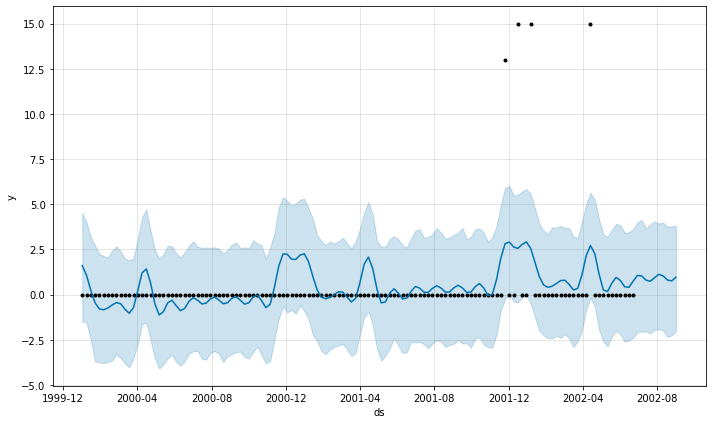

In [133]:
fig1 = m.plot(forecast)

In [117]:
val_data['meal_id'].value_counts()

1727    385
2826    385
2707    385
1778    385
2290    385
1109    385
1062    385
1558    385
2664    385
1993    385
1754    385
1962    385
2490    385
2569    385
1885    384
1971    382
2581    382
2539    381
2322    379
1207    375
1230    370
2704    369
1543    369
2640    368
2631    366
1216    361
1248    357
2304    355
1525    347
2126    346
1878    339
2760    337
2139    331
2492    323
2306    296
1902    294
2577    292
1571    282
1445    281
1247    279
2444    273
2867    251
1770    224
2956    222
2104    190
1803    172
1311    170
1198    159
1438    158
1847    152
2494    139
Name: meal_id, dtype: int64

In [118]:
val_data['center_id'].value_counts()

13     255
10     254
52     254
174    252
51     252
      ... 
57     159
139    156
162    150
41     143
91     139
Name: center_id, Length: 77, dtype: int64

In [119]:
val_data[(val_data['meal_id'] == 2494) & (val_data['center_id'] == 91)]

,week,center_id,meal_id,num_orders


In [134]:
pickle.dump(new_full_raw_time_series, open('new_full_raw_time_series.pkl','wb'))
print('Done Pickling')

Done Pickling


In [135]:
# def predict_demand(center_meal_combo_id):
#     mini_time_series = new_full_raw_time_series.loc[new_full_raw_time_series['center_meal_combo_id'] == '91-2494',['ds','y']]
#     #mini_time_series.head()
#     m = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
#     m.fit(mini_time_series)
#     # Make a dataframe of future dates
#     future = m.make_future_dataframe(freq='W', periods=10)
#     # Make predictions on future dates
#     forecast = m.predict(future)
#     predictions = forecast.loc[:,['ds','yhat']] 
# new_full_raw_time_series

,week,ds,center_meal_combo_id,y
0,1,2000-01-02,10-1062,865.0
1,2,2000-01-09,10-1062,782.0
2,3,2000-01-16,10-1062,851.0
3,4,2000-01-23,10-1062,1202.0
4,5,2000-01-30,10-1062,958.0
...,...,...,...,...
510505,126,2002-05-26,186-2956,0.0
510506,127,2002-06-02,186-2956,0.0
510507,128,2002-06-09,186-2956,0.0
510508,129,2002-06-16,186-2956,0.0


In [143]:
#total_predictions.to_csv('total_predictions.csv', index = False)
# tp = total_predictions.copy()
# tp = tp.dropna()
# print(total_predictions.shape)
# print(tp.shape)
# tp.to_csv('total_predictions_final.csv', index = False)
# print('File Creaated :D')

(569415, 3)
(549780, 3)
File Creaated :D
